## Project 1 report

### Name (SID): Joshua Hewitt (460264208)

Please follow the instructions carefully:
- This project is based on Cifar-10 dataset. The basic loading operations are added already. Please do not use other dataset.
- Remove the corresponding `e.g.` and fill in all the blanks in this file, including some codes in Part 1, your choices for Part 2, your task for Part 3, and the analyses for your choices, specification of your computer, etc.
- Please do not change the format of this report.
- In your analyses, you can add math functions and graphs.
- Please make clear comments and references for any codes written by yourself or copied from other sources.

### Part 0: Prepare for Colab

If you work on [Google Colab](https://colab.research.google.com), you need to first install PyTorch each time you run the file. You can also upload file and load files from your google drive.
Besides, you can also select GPU as Hardware accelerator in Edit->Notebook settings. 

Remember to run some of the following blocks if you work on Google Colab. You can ignore this part if you are not using Google Colab.

### Part 1: Baseline model
You need to run this model successfully to get the marks. You should finish the codes that are used to split the training dataset into training set (45000 images) and validation set (5000 images) and draw the loss curve for training loss and validation loss. You only need to change the codes in 1.2 and 1.6 for successfuly experiments.

### 1.1 prepare data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F



transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

print('initial trainset length')
print(len(trainset))
print('testset length')
print(len(testset))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
initial trainset length
50000
testset length
10000


### 1.2 split the training data into training and validation
In most of the cases, you are given the test set, so you need to prepare some validation data to evaluate your model during training stage. You need to make a validation dataset that contains 5000 training images, and the rest 45000 images are used as the new training set.

In [2]:
# Your split codes comes here.
# You need to random select the 5000 validation images 



# found here: https://pytorch.org/docs/stable/data.html
valset, trainset = torch.utils.data.random_split(trainset, [5000,45000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

valloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                         shuffle=False, num_workers=0)

def evaluate_validation_set(net, valloader, criterion):
    correct = 0
    total = 0
    running_loss = 0.0
    count = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            count += 1

    accuracy = correct / total
    loss = running_loss/count
    return accuracy, loss
# besides, you can also make modifications for faster training 
# by selecting a subset of the original dataset.

### 1.3 Define a Baseline Convolution Neural Network

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 1.4 Define a Loss function and optimizer

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


### 1.5 Train the network

In [5]:
iteration_log = []
loss_log = []
accuracy_log = []
validation_loss_log = []
validation_accuracy_log = []
visualizer_iteration = 1000
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss2 = 0.0
    running_total = 0
    running_correct = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #get accuracy 
        _, predicted = torch.max(outputs.data, 1)
        running_total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        # print statistics
        running_loss += loss.item()
        running_loss2 += loss.item()

        if i % visualizer_iteration == 0 and i != 0:
            accuracy, loss = evaluate_validation_set(net, valloader, criterion)
            validation_accuracy_log.append(accuracy)
            validation_loss_log.append(loss)

            iteration_log.append(len(trainloader)*(epoch) + i)
            if i != 0:
                accuracy_log.append(running_correct/running_total)
                loss_log.append(running_loss2/visualizer_iteration)
            else:
                accuracy_log.append(running_correct)
                loss_log.append(running_loss2)
        
            running_correct = 0
            running_total = 0
            running_loss2 = 0.0
            # print('iteration_log:')
            # print(iteration_log)
            # print('loss_log:')
            # print(loss_log)
            # print('accuracy_log:')
            # print(accuracy_log)

        if i % 2000 == 1999:    # print every 2000 mini-batches

            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.303
[1,  4000] loss: 2.216
[1,  6000] loss: 2.021
[1,  8000] loss: 1.878
[1, 10000] loss: 1.772
[2,  2000] loss: 1.631
[2,  4000] loss: 1.571
[2,  6000] loss: 1.545
[2,  8000] loss: 1.512
[2, 10000] loss: 1.478
Finished Training


### 1.6 visualize the loss and accuracy
Using the loss of both training data and validation data to evaluate the model.

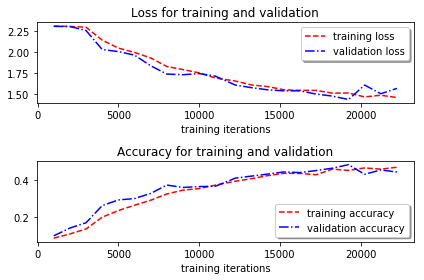

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# functions to show the loss

plt.figure(1)

plt.subplot(211)
plt.plot(iteration_log, loss_log, 'r--', label = 'training loss')
plt.plot(iteration_log, validation_loss_log, 'b-.', label = 'validation loss')
plt.title('Loss for training and validation')
plt.xlabel('training iterations')
legend = plt.legend(loc='upper right', shadow=True)
plt.subplot(212)
plt.plot(iteration_log, accuracy_log, 'r--', label = 'training accuracy')
plt.plot(iteration_log, validation_accuracy_log, 'b-.', label = 'validation accuracy')
plt.title('Accuracy for training and validation')
plt.xlabel('training iterations')
legend = plt.legend(loc='lower right', shadow=True)

plt.tight_layout()
plt.show()



### 1.7 Eval the trained network

In [7]:
def eval_net(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

eval_net(net, testloader)

Accuracy of the network on the 10000 test images: 48 %


### Part 2: Hyperparameters Selection
Following the instruction file, you need to make choices for each hyperparameters:

1. Batch size:
2. Base learning rate:
3. Number of epochs: 

**Question**: Why do you make such choices? Use some figures, math equations, codes and printout to make analysis.

In [8]:
# Your codes comes here. 
# Please do not define the networks again, just make changes to the training procedure.


##### your analysis comes here:
-----
1) 

2) 



### Part 3: More options

Please indicate the three tasks you are assigned here:

1) Transformation: e.g. Resize (hyperparameters: size, interpolation), ...

2) Structure: 

3) Training procedure: 

For your new baseline and the test for different options, you need to write them in **ONE** single `.py` file. You can debug here, but do **NOT** include your codes in the submitted ipynb file. Your codes for this part will be put in the **project1.py** file.

**Question**: how do you define your new baseline and why? Please highlight the differences between your new baseline and the previous baseline.

##### your analysis comes here:
-----
1) 

2) 


_____

**Question**: how did you test the three tasks and what did you learn? Please use some figures, math equations and output from your codes to make analysis. 

##### your analysis comes here:
-----
1) 

2) 


_____

### Reference
1. Author, Title, url
2. 
3. 

### Specs:
e.g. Your cpu version or GPU version, the memory size of your computer. Your software versions.